In [1]:
# Step 1: Create Lag Features & Time-Based Features
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Load cleaned data
df = pd.read_csv('beijing_air_quality_cleaned.csv', index_col='datetime', parse_dates=True)
print(f"Data shape: {df.shape}")

# ============================================
# 1. CREATE LAG FEATURES
# ============================================

print("Creating lag features...")

# Important lags for hourly data
lags = [1, 2, 3, 6, 12, 24]  # hours ago
for lag in lags:
    df[f'pm2.5_lag_{lag}h'] = df['pm2.5'].shift(lag)

# ============================================
# 2. CREATE ROLLING STATISTICS
# ============================================

print("Creating rolling statistics...")

# Rolling windows (hours)
windows = [3, 6, 12, 24]
for window in windows:
    df[f'pm2.5_roll_mean_{window}h'] = df['pm2.5'].rolling(window=window, min_periods=1).mean().shift(1)
    df[f'pm2.5_roll_std_{window}h'] = df['pm2.5'].rolling(window=window, min_periods=1).std().shift(1)
    df[f'pm2.5_roll_min_{window}h'] = df['pm2.5'].rolling(window=window, min_periods=1).min().shift(1)
    df[f'pm2.5_roll_max_{window}h'] = df['pm2.5'].rolling(window=window, min_periods=1).max().shift(1)

# ============================================
# 3. CREATE TIME-BASED FEATURES
# ============================================

print("Creating time-based features...")

# Cyclical time features (sine/cosine for hour, month)
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

# Time features
df['hour'] = df.index.hour
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek  # Monday=0, Sunday=6
df['day_of_month'] = df.index.day
df['week_of_year'] = df.index.isocalendar().week
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
df['quarter'] = df.index.quarter

# Seasons (categorical)
df['season'] = df['month'].apply(lambda x: 0 if x in [12,1,2] else  # Winter
                                           1 if x in [3,4,5] else   # Spring
                                           2 if x in [6,7,8] else   # Summer
                                           3)                      # Autumn

# ============================================
# 4. CREATE WEATHER INTERACTION FEATURES
# ============================================

print("Creating interaction features...")

# Basic interactions
df['temp_dewp'] = df['TEMP'] * df['DEWP']
df['pres_iws'] = df['PRES'] * df['Iws']
df['temp_pres'] = df['TEMP'] * df['PRES']

# Wind speed categories
df['wind_speed_cat'] = pd.cut(df['Iws'], 
                               bins=[0, 5, 10, 20, 100], 
                               labels=['calm', 'moderate', 'strong', 'storm'])

# ============================================
# 5. ENCODE CATEGORICAL VARIABLES
# ============================================

print("Encoding categorical variables...")

# One-hot encode wind direction (already exists as wind_NE, etc. from EDA)
# If not, create it:
if 'cbwd' in df.columns:
    df = pd.get_dummies(df, columns=['cbwd'], prefix='wind')

# One-hot encode wind speed category
df = pd.get_dummies(df, columns=['wind_speed_cat'], prefix='wind_speed')

# ============================================
# 6. HANDLE MISSING VALUES FROM LAG CREATION
# ============================================

print("Handling missing values from lag creation...")

# Drop rows with NaN from lag features (first 24 rows)
initial_rows = df.shape[0]
df = df.dropna()
print(f"Dropped {initial_rows - df.shape[0]} rows due to lag features")
print(f"New shape: {df.shape}")

# ============================================
# 7. HANDLE OUTLIERS (CAPPING)
# ============================================

print("Handling outliers...")

# I'll cap PM2.5 at 99th percentile (safer than arbitrary 500)
pm25_99th = df['pm2.5'].quantile(0.99)
print(f"99th percentile of PM2.5: {pm25_99th:.2f} µg/m³")

# Cap values above 99th percentile
df['pm2.5_original'] = df['pm2.5'].copy()  # Keep original
df['pm2.5'] = np.where(df['pm2.5'] > pm25_99th, pm25_99th, df['pm2.5'])

print(f"Capped {len(df[df['pm2.5_original'] > pm25_99th])} values > {pm25_99th:.2f}")

# ============================================
# 8. CREATE TARGET VARIABLE (t+1)
# ============================================

print("Creating target variable (PM2.5 at t+1)...")

df['target_pm2.5'] = df['pm2.5'].shift(-1)

# Drop last row (no target for it)
df = df.iloc[:-1]

print(f"Final dataset shape: {df.shape}")
print(f"Features created: {len(df.columns)}")
print(f"\nSample of new features:")
print(df[['pm2.5', 'pm2.5_lag_1h', 'pm2.5_lag_24h', 
          'pm2.5_roll_mean_6h', 'target_pm2.5']].head(10))

Data shape: (43824, 16)
Creating lag features...
Creating rolling statistics...
Creating time-based features...
Creating interaction features...
Encoding categorical variables...
Handling missing values from lag creation...
Dropped 2067 rows due to lag features
New shape: (41757, 57)
Handling outliers...
99th percentile of PM2.5: 420.00 µg/m³
Capped 416 values > 420.00
Creating target variable (PM2.5 at t+1)...
Final dataset shape: (41756, 58)
Features created: 58

Sample of new features:
                     pm2.5  pm2.5_lag_1h  pm2.5_lag_24h  pm2.5_roll_mean_6h  \
datetime                                                                      
2010-01-02 00:00:00  129.0         129.0          129.0          129.000000   
2010-01-02 01:00:00  148.0         129.0          129.0          129.000000   
2010-01-02 02:00:00  159.0         148.0          129.0          132.166667   
2010-01-02 03:00:00  181.0         159.0          129.0          137.166667   
2010-01-02 04:00:00  138.0      

In [2]:
# Step 2: Prepare Features & Target
# ============================================
# SEPARATE FEATURES & TARGET
# ============================================

print("\n" + "="*50)
print("PREPARING FEATURES & TARGET")
print("="*50)

# Drop columns not used as features
X = df.drop(columns=['target_pm2.5', 'pm2.5_original'])
if 'pm2.5' in X.columns:
    X = X.drop(columns=['pm2.5'])  # Current PM2.5 is not available at prediction time

y = df['target_pm2.5']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Check for any remaining NaN
print(f"\nRemaining NaN in X: {X.isnull().sum().sum()}")
print(f"Remaining NaN in y: {y.isnull().sum()}")

# Feature list
print(f"\nTotal features: {len(X.columns)}")
print("\nFeature categories:")
print(f"- Lag features: {len([c for c in X.columns if 'lag' in c])}")
print(f"- Rolling features: {len([c for c in X.columns if 'roll' in c])}")
print(f"- Time features: {len([c for c in X.columns if c in ['hour', 'month', 'day_of_week', 'season']])}")
print(f"- Weather features: {len([c for c in X.columns if c in ['TEMP', 'DEWP', 'PRES', 'Iws', 'Is', 'Ir']])}")
print(f"- Encoded features: {len([c for c in X.columns if 'wind_' in c])}")

# Save the feature-engineered dataset
df.to_csv('beijing_air_quality_featured.csv')
print(f"\nSaved featured dataset: 'beijing_air_quality_featured.csv'")


PREPARING FEATURES & TARGET
X shape: (41756, 55)
y shape: (41756,)

Remaining NaN in X: 0
Remaining NaN in y: 0

Total features: 55

Feature categories:
- Lag features: 6
- Rolling features: 16
- Time features: 4
- Weather features: 6
- Encoded features: 8

Saved featured dataset: 'beijing_air_quality_featured.csv'


In [3]:
# Step 3: Time-Series Cross-Validation Setup
# ============================================
# 10. TIME-SERIES CROSS-VALIDATION
# ============================================

print("\n" + "="*50)
print("TIME-SERIES CROSS-VALIDATION SETUP")
print("="*50)

# For time-series, we need to maintain order
X_sorted = X.sort_index()
y_sorted = y.sort_index()

# Create time-series CV (5 folds)
tscv = TimeSeriesSplit(n_splits=5, test_size=24*30)  # 30 days test each fold
print(f"Number of folds: {tscv.n_splits}")

# Show train/test sizes for each fold
fold_info = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_sorted)):
    train_dates = X_sorted.iloc[train_idx].index
    test_dates = X_sorted.iloc[test_idx].index
    fold_info.append({
        'fold': fold + 1,
        'train_start': train_dates[0],
        'train_end': train_dates[-1],
        'test_start': test_dates[0],
        'test_end': test_dates[-1],
        'train_size': len(train_idx),
        'test_size': len(test_idx)
    })

fold_df = pd.DataFrame(fold_info)
print("\nCross-validation folds:")
print(fold_df.to_string(index=False))


TIME-SERIES CROSS-VALIDATION SETUP
Number of folds: 5

Cross-validation folds:
 fold train_start           train_end          test_start            test_end  train_size  test_size
    1  2010-01-02 2014-08-01 11:00:00 2014-08-01 12:00:00 2014-08-31 22:00:00       38156        720
    2  2010-01-02 2014-08-31 22:00:00 2014-08-31 23:00:00 2014-10-01 03:00:00       38876        720
    3  2010-01-02 2014-10-01 03:00:00 2014-10-01 04:00:00 2014-10-31 04:00:00       39596        720
    4  2010-01-02 2014-10-31 04:00:00 2014-10-31 05:00:00 2014-11-30 18:00:00       40316        720
    5  2010-01-02 2014-11-30 18:00:00 2014-11-30 19:00:00 2014-12-31 22:00:00       41036        720



FEATURE-TARGET CORRELATION
Columns in X:
['No', 'year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'year_month', 'season', 'pm2.5_lag_1h', 'pm2.5_lag_2h', 'pm2.5_lag_3h', 'pm2.5_lag_6h', 'pm2.5_lag_12h', 'pm2.5_lag_24h', 'pm2.5_roll_mean_3h', 'pm2.5_roll_std_3h', 'pm2.5_roll_min_3h', 'pm2.5_roll_max_3h', 'pm2.5_roll_mean_6h', 'pm2.5_roll_std_6h', 'pm2.5_roll_min_6h', 'pm2.5_roll_max_6h', 'pm2.5_roll_mean_12h', 'pm2.5_roll_std_12h', 'pm2.5_roll_min_12h', 'pm2.5_roll_max_12h', 'pm2.5_roll_mean_24h', 'pm2.5_roll_std_24h', 'pm2.5_roll_min_24h', 'pm2.5_roll_max_24h', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_of_week', 'day_of_month', 'week_of_year', 'is_weekend', 'quarter', 'temp_dewp', 'pres_iws', 'temp_pres', 'wind_NE', 'wind_NW', 'wind_SE', 'wind_cv', 'wind_speed_calm', 'wind_speed_moderate', 'wind_speed_strong', 'wind_speed_storm']

Data types in X:
float64    32
int64       8
bool        8
int32       5
object      1
UInt32      1
Name: count, dtyp

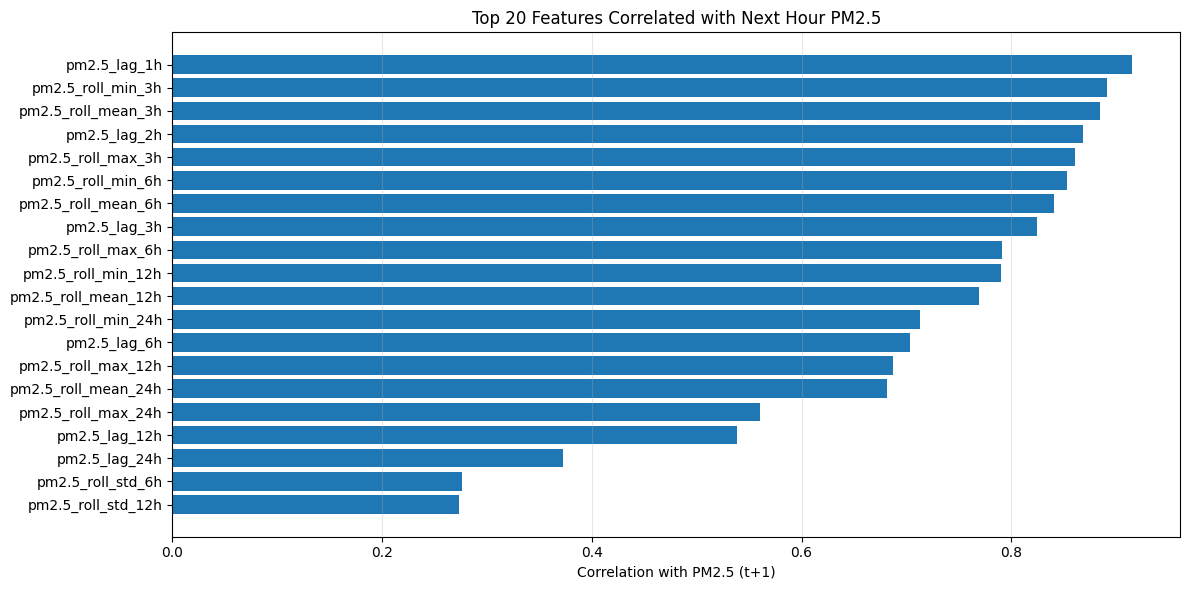


Total numeric features for modeling: 46

No constant features found.

No extremely low variance features found.


In [4]:
# Step 4: Quick Feature Importance (Baseline)
# ============================================
# QUICK FEATURE CORRELATION WITH TARGET
# ============================================

print("\n" + "="*50)
print("FEATURE-TARGET CORRELATION")
print("="*50)

# First, let's see what columns are in X
print("Columns in X:")
print(X.columns.tolist())

# Check data types
print("\nData types in X:")
print(X.dtypes.value_counts())

# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object', 'datetime', 'category']).columns
print(f"\nNon-numeric columns: {list(non_numeric_cols)}")

# Drop non-numeric columns for correlation calculation
X_numeric = X.select_dtypes(include=[np.number])

print(f"\nNumeric features: {len(X_numeric.columns)}")
print(f"Non-numeric features removed: {len(X.columns) - len(X_numeric.columns)}")

# Now calculate correlation with target
X_sorted = X_numeric.sort_index()
y_sorted = y.sort_index()

correlations = X_sorted.corrwith(y_sorted).sort_values(ascending=False)
print("\nTop 20 features correlated with target (t+1 PM2.5):")
print("-" * 60)
for i, (feat, corr) in enumerate(correlations.head(20).items()):
    print(f"{i+1:2}. {feat:30} : {corr:.4f}")

print("\nBottom 10 features:")
print("-" * 60)
for i, (feat, corr) in enumerate(correlations.tail(10).items()):
    print(f"{i+1:2}. {feat:30} : {corr:.4f}")

# Visualize top correlations
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
top_20 = correlations.head(20)
plt.barh(range(len(top_20)), top_20.values)
plt.yticks(range(len(top_20)), top_20.index)
plt.xlabel('Correlation with PM2.5 (t+1)')
plt.title('Top 20 Features Correlated with Next Hour PM2.5')
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save numeric feature list for modeling
feature_list = X_numeric.columns.tolist()
print(f"\nTotal numeric features for modeling: {len(feature_list)}")

# Save feature list
with open('feature_list.txt', 'w') as f:
    for feat in feature_list:
        f.write(f"{feat}\n")

# Also check for constant features
constant_features = X_numeric.columns[X_numeric.nunique() == 1]
if len(constant_features) > 0:
    print(f"\nConstant features (remove these): {list(constant_features)}")
else:
    print("\nNo constant features found.")

# Check for low variance features
variance = X_numeric.var()
low_variance_features = variance[variance < 0.01].index.tolist()
if low_variance_features:
    print(f"\nLow variance features (<0.01): {low_variance_features}")
else:
    print("\nNo extremely low variance features found.")

In [5]:
# Update X_numeric after cleaning
X_numeric = X.select_dtypes(include=[np.number])
print(f"Final numeric features: {len(X_numeric.columns)}")

Final numeric features: 46
